In [54]:
import numpy as np 
import pickle 

In [65]:
def closest_index(arr, value):
    arr = np.asarray(arr)
    return np.argmin(np.abs(arr - value))

In [66]:
from spisea import reddening 

fritz_law = reddening.RedLawFritz11() 
wavelength, extinction, error = fritz_law._read_Fritz11() 

In [67]:
# fritz ratios
def ratio_and_error(x, sigx, y, sigy):
    r  = (x / y)[0]
    sigr = (r * np.sqrt((sigx / x)**2 + (sigy / y)**2))[0]
    return (r, sigr)

idx115 = closest_index(wavelength, 1.15)
idx140 = closest_index(wavelength, 1.40)
idx182 = closest_index(wavelength, 1.82)
idx212 = closest_index(wavelength, 2.12)
idx323 = closest_index(wavelength, 3.23)
idx405 = closest_index(wavelength, 4.05)

A115e = error[idx115]
A140e = error[idx140]
A182e = error[idx182]
A212e = error[idx212]
A323e = error[idx323]
A405e = error[idx405]

A115 = fritz_law.Fritz11(wavelength=1.15, A_scale_lambda=2.166)
A140 = fritz_law.Fritz11(wavelength=1.40, A_scale_lambda=2.166)
A182 = fritz_law.Fritz11(wavelength=1.82, A_scale_lambda=2.166)
A212 = fritz_law.Fritz11(wavelength=2.12, A_scale_lambda=2.166)
A323 = fritz_law.Fritz11(wavelength=3.23, A_scale_lambda=2.166)
A405 = fritz_law.Fritz11(wavelength=4.05, A_scale_lambda=2.166)

fritz_ratios = {
    "AF115W/AF212N": ratio_and_error(A115, A115e, A212, A212e),
    "AF140M/AF212N": ratio_and_error(A140, A140e, A212, A212e),
    "AF182M/AF212N": ratio_and_error(A182, A182e, A212, A212e),
    "AF212N/AF212N": ratio_and_error(A212, A212e, A212, A212e),
    "AF323N/AF212N": ratio_and_error(A323, A323e, A212, A212e),
    "AF405N/AF212N": ratio_and_error(A405, A405e, A212, A212e),
}

In [68]:
import pickle, os 
from pathlib import Path 

with open("ratios.pickle", "rb") as f: 
    extinction_ratios = pickle.load(f)

extinction_ratios

{'NRCB1': {'AF115W/AF212N': (3.344534245292499, 0.1156767142301079),
  'AF140M/AF212N': (2.3419269184527125, 0.09341853948756694),
  'AF212N/AF212N': (1.0, 0.0),
  'AF323N/AF212N': (0.9134131771431971, 0.08557307099325737),
  'AF405N/AF212N': (0.4603120119995674, 0.02706553776470757)},
 'NRCB2': {'AF115W/AF212N': (3.3230995555013885, 0.04418875805977559),
  'AF140M/AF212N': (2.520479757751345, 0.11322858171718167),
  'AF182M/AF212N': (1.2748075237681524, 0.04887609275350659),
  'AF212N/AF212N': (1.0, 0.0),
  'AF323N/AF212N': (0.6870369308233681, 0.09460294892679987),
  'AF405N/AF212N': (0.40740177599308874, 0.021904765635100028)},
 'NRCB3': {'AF115W/AF212N': (3.4408888739298744, 0.19867582250013238),
  'AF140M/AF212N': (2.5882428766589354, 0.15401490336986406),
  'AF182M/AF212N': (1.393518162618213, 0.08554073977157457),
  'AF212N/AF212N': (1.0, 0.0),
  'AF323N/AF212N': (0.8172431584019595, 0.09263693043509437),
  'AF405N/AF212N': (0.39927422785547384, 0.05543405263522338)},
 'NRCB4': 

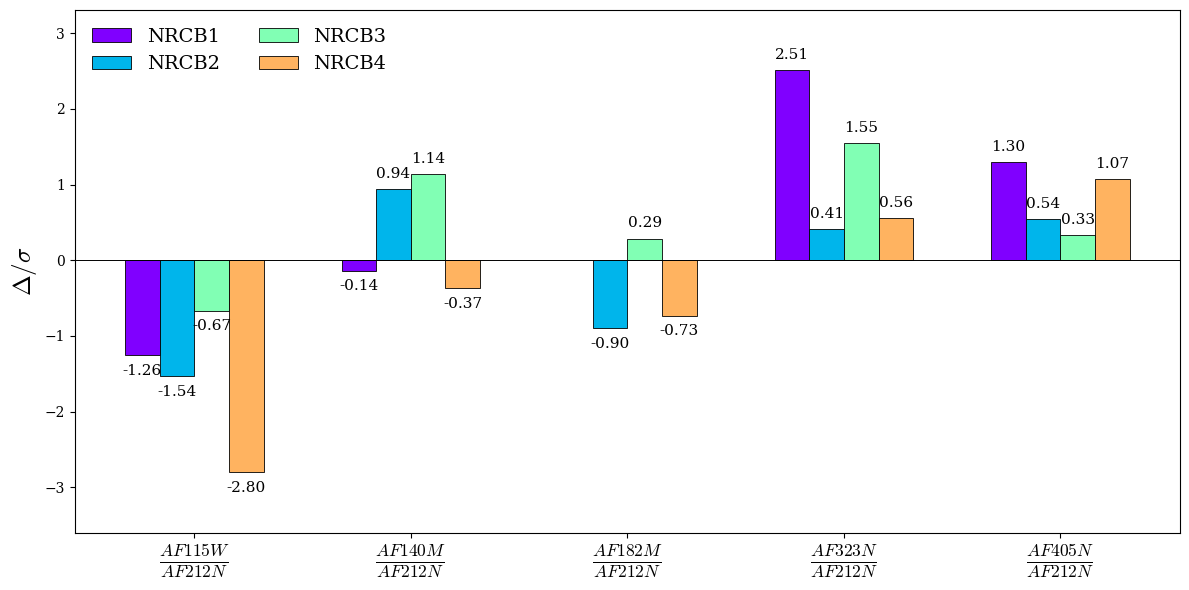

In [69]:
import matplotlib.pyplot as plt
from cycler import cycler

plt.rcParams['font.family']      = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

nice5 = plt.get_cmap("rainbow")(np.linspace(0, 1, 5))
plt.rcParams["axes.prop_cycle"] = cycler(color=nice5)

regions = list(extinction_ratios.keys())
ratios  = [b for b in fritz_ratios.keys() if not b.startswith("AF212N")]

x = np.arange(len(ratios))
width = 0.16 

fig, ax = plt.subplots(figsize=(12, 6))

for i, region in enumerate(regions):
    sigmas = []
    for band in ratios:
        if band not in extinction_ratios[region]:
            sigmas.append(np.nan)
            continue
        meas, meas_err = extinction_ratios[region][band]
        ref,  ref_err  = fritz_ratios[band]
        total_err      = np.hypot(meas_err, ref_err)
        sigmas.append((meas - ref) / total_err)

    offset = (i - (len(regions)-1)/2) * width
    bars = ax.bar(
        x + offset, sigmas, width,
        label=region, edgecolor='k', linewidth=0.6
    )

    for bar, sigma in zip(bars, sigmas):
        if np.isnan(sigma):
            continue
        y = bar.get_height()
        pad = 6  # points
        ax.annotate(f"{sigma:.2f}",
                    xy=(bar.get_x() + bar.get_width()/2, y),
                    xytext=(0, pad if y >= 0 else -pad),
                    textcoords='offset points',
                    ha='center',
                    va='bottom' if y >= 0 else 'top',
                    fontsize=11,
                    clip_on=False)

ax.axhline(0, color='k', lw=0.7)

ax.set_xticks(x)
ax.set_xticklabels(
    [fr'$\frac{{A{b.split("/")[0][1:]}}}{{A{b.split("/")[1][1:]}}}$' for b in ratios],
    fontsize=18
)
ax.set_ylabel(r'$\Delta/\sigma$', fontsize=18)

ax.legend(ncol=2, fontsize=14, frameon=False, loc='upper left')

ax.margins(y=0.15)
plt.tight_layout()
plt.savefig("significance.png", dpi=300)